# <font color='red'>Backtest vectorizado para una estrategia 'kalman'.</font>

### Hackeado by J3viton (learning BackTesting 2021).

---

En este notebook vamos a automatizar el backtesting para estrategias. Previamente tenemos que definir **la estrategia** usando el template (import estrategia_XX as rg), donde definimos la clase estrategia que contiene los metodos de analisis, entreda y salida de mercado. Este módulo se programa y adapta para cada estrategia. Luego en el metodo 'analisis' se crea un fichero excel con las metricas y rendimientos para evaluar la estrategia.

Vamos a usar el módulo Pandas, para realizar un backtest vectorizado, es decir calcular el resultado del backtest sin iterar sobre las filas (barras) de la serie temporal.

Posteriormente graficamos y mostramos los parametros generales que nos permiten analizar la estrategia.

#### J3Viton  2021

link a la base:

https://github.com/Python-para-Trading/Webinars-Docs/blob/master/Webinar%202/Webinar%202%20-%20Backtest%20con%20Pandas%20v%202.ipynb.

---

# DEFINICION DEL SISTEMA

Como es usual, importamos los módulos que vamos a necesitar para las distintas tareas, y preparamos Matplotlib para una mejor visualización de los gráficos en el notebook.

Se importa un modulo llamado analisis, en realidad se trata de un archivo .py con algunas funciones de apoyo para el trabajo, debe estar guardado en la misma carpeta que este notebook.
Se importa el módulo 'estrategia_XX', donde se define la estrategia de entreda y salida

Es importante tener clara la lógica del sistema, pues debemos plasmarla de forma sencilla y correcta en el dataframe para realizar el backtest del mismo.


In [1]:
import analisis
import kalman as rg  #cambiar segun el módulo con la estrategia implementado
import pandas as pd
import datetime as dt
from time import time
import yfinance as yf
import numpy as np

{'id': 1473252352, 'first_name': 'vital_bot', 'is_bot': True, 'username': 'vital_quant_bot', 'can_join_groups': True, 'can_read_all_group_messages': False, 'supports_inline_queries': False}


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 8
plt.style.use('ggplot')

from IPython.display import display, Markdown

***0.- RECOGIDA DE DATOS INICIALES***
Introducimos el instrumento y las fechas


In [3]:
instrumento_ = 'FANG'   # ticker del valor en yahooFinance

Fecha_Cominezo_Backtesting = dt.datetime(2013,1,2)  #Dejale margen para hacer las medias moviles, como un año antes
Fecha_Final_Backtesting    = dt.datetime(2021,5,5)




***1.- Rango fechas a analizar***

Definimos el rango global de datos historicos que vamos a evaluar.
Definimos la ventana que vamos a ir desplazando por todo el espectro para ir analilazando como se comporta la estrategia. La funion 'analisis' nos vale para tiempo real y para backtesting, para back le pasamos la ventana como si la fecha de fin de la ventana fuera la fecha de hoy.
Tener en cuenta que la 'ventana' tiene uqe tener una anchura que nos permita hacer los calculos en rolling (ejemplo EMA 200)

In [4]:
# Rango completo para backTesting
#start2 =dt.datetime(2008,1,2)
start2= Fecha_Cominezo_Backtesting 
#end2   =dt.datetime(2021,11,18)
end2= Fecha_Final_Backtesting 
start_G= start2.strftime("%Y-%m-%d")
end_G  =   end2.strftime("%Y-%m-%d")
TOTAL_len= (end2-start2).days
print('Tamaño timeseries global a analizar:  ', TOTAL_len, 'sesiones')

#ventana de analisis 1000 sesiones
#startWindow2 =dt.datetime(2008,1,5)
startWindow2= Fecha_Cominezo_Backtesting 
endWindow2   =startWindow2 + dt.timedelta(days=600) #ventana grande para que se puedan hacer los calculos de EMA200
startWindow= startWindow2.strftime("%Y-%m-%d")
endWindow  =   endWindow2.strftime("%Y-%m-%d")
window_len= (endWindow2-startWindow2).days
print('Tamaño de la ventana a analizar paso a paso:  ', window_len, 'sesiones')

Tamaño timeseries global a analizar:   3045 sesiones
Tamaño de la ventana a analizar paso a paso:   600 sesiones


In [5]:
 #dff = pd.DataFrame(columns=('Close','Volume', 'Senal', 'Dif_Close', 'Retornos','Capital'))

***2.- Descargamos los datos para el marco Global***

In [6]:
instrumento = instrumento_  # 'rovi.mc'  #Vamos título a título. Mejora: Conjunto de títulos

In [7]:
dff = yf.download(instrumento, start_G,end_G)

[*********************100%***********************]  1 of 1 completed


In [8]:
dff.dropna(inplace=True)  
dff.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.459999,19.920000,18.600000,19.240000,17.499462,189700
2013-01-03,19.240000,19.459999,18.650000,19.139999,17.408510,89100
2013-01-04,19.250000,20.490000,18.969999,20.049999,18.236185,173300
2013-01-07,19.889999,21.240000,19.639999,20.770000,18.891056,210300
2013-01-08,20.690001,21.100000,20.379999,20.600000,18.736429,229400


***3.- Creamos la clase strategy que tiene toda la lógica***

In [9]:
regreMedia= rg.StrategyClass(real_back=True)    #Creamos la clase  true-> backTesting

***4.- Recorremos el dataframe con valores buscando las señales de la estrategia***

In [10]:
dff.index

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-14', '2013-01-15',
               ...
               '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-26',
               '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30',
               '2021-05-03', '2021-05-04'],
              dtype='datetime64[ns]', name='Date', length=2099, freq=None)

In [11]:
instrumento


'FANG'

## Proceso de backTesting ##

En este 'for' vamos recorriendo la muestra del historico de datos (TOTAL), desplazando una sesión hacia el futuro 
en cada iteracion. Vamos pasando la movilola del pasado sesión a sesión por el análisis descrito en Strategy class.

Ouput:
El sistema registra los siguientes parámetros:

.-
.-
.-


In [12]:
startWindow2

datetime.datetime(2013, 1, 2, 0, 0)

In [13]:
endWindow2

datetime.datetime(2014, 8, 25, 0, 0)

In [14]:
tiempo_inicial = time()   # Tomamos tiempos para ver cuanto tarda en hacer la estrategia

In [15]:
dfe = pd.DataFrame({'A' : []})   #df empty

***En este 'for' desplazamos la ventana sesión a sesión a lo largo de todo el rango de fechas. Dejamos que las funciones de la clase estrategia hagan el trabajo de comprar//vender y anotar***


end date: 2014-08-25
DDatos desde archivo
FANG
Coefficients: 
 [0.16537062]
Independent term: 
 33.23243233268367
FANG False
Precio 79.77999877929688 *************  Kalman 80.35488496853861
checkIN Time 2014-08-22 00:00:00


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737        99
................................................Analizando, muestra 0 de 3045 fecha 2014-08-25
end date: 2014-08-26
DDatos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16570849]
Independent term: 
 33.360979670658395
FANG False
Precio 80.0 *************  Kalman 80.56084114555014
checkIN Time 2014-08-25 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737        99
......

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16604316]
Independent term: 
 33.48978598626266
FANG False
Precio 80.23999786376953 *************  Kalman 80.69853932194799
checkIN Time 2014-08-26 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16637538]
Independent term: 
 33.618793115343976
FANG False
Precio 80.73999786376953 *************  Kalman 80.87544773855022
checkIN Time 2014-08-27 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16670713]
Independent term: 
 33.74793369963774
FANG False
Precio 79.9800033569336 *************  Kalman 81.23549153876714
checkIN Time 2014-08-28 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16703565]
Independent term: 
 33.87738502249789
FANG False
Precio 81.4000015258789 *************  Kalman 81.4280409514534
checkIN Time 2014-08-29 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737       

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.1673616]
Independent term: 
 34.00709326350653
FANG False
Precio 83.87999725341797 *************  Kalman 81.65607234891212
checkIN Time 2014-09-02 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16768153]
Independent term: 
 34.13727939270788
FANG False
Precio 82.5999984741211 *************  Kalman 81.61141116638633
checkIN Time 2014-09-03 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16799538]
Independent term: 
 34.2681045742832
FANG False
Precio 83.19999694824219 *************  Kalman 81.54243706341727
checkIN Time 2014-09-04 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16830169]
Independent term: 
 34.39973950214814
FANG False
Precio 86.3499984741211 *************  Kalman 81.35128126921423
checkIN Time 2014-09-05 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16859974]
Independent term: 
 34.5322363031914
FANG False
Precio 83.2300033569336 *************  Kalman 81.05473849391024
checkIN Time 2014-09-08 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737       

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16888994]
Independent term: 
 34.665407178632535
FANG False
Precio 83.83999633789062 *************  Kalman 80.75606408333859
checkIN Time 2014-09-09 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16917341]
Independent term: 
 34.799169904669
FANG False
Precio 79.5 *************  Kalman 80.48829809533659
checkIN Time 2014-09-10 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737        99
.........

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16944954]
Independent term: 
 34.93357064564549
FANG False
Precio 79.25 *************  Kalman 80.1548170607009
checkIN Time 2014-09-11 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737        99
.......

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16971814]
Independent term: 
 35.06858640158923
FANG False
Precio 77.41999816894531 *************  Kalman 79.81191759365491
checkIN Time 2014-09-12 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16998071]
Independent term: 
 35.20419326928551
FANG False
Precio 76.45999908447266 *************  Kalman 79.60719972971704
checkIN Time 2014-09-15 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17023654]
Independent term: 
 35.34047684599605
FANG False
Precio 76.80000305175781 *************  Kalman 79.40394536715442
checkIN Time 2014-09-16 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17048426]
Independent term: 
 35.47751019131532
FANG False
Precio 77.87000274658203 *************  Kalman 79.13901417348326
checkIN Time 2014-09-17 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17072304]
Independent term: 
 35.61538175288527
FANG False
Precio 76.55999755859375 *************  Kalman 78.85041709321915
checkIN Time 2014-09-18 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17095248]
Independent term: 
 35.7540277473592
FANG False
Precio 76.23999786376953 *************  Kalman 78.464113863377
checkIN Time 2014-09-19 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737        

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17117258]
Independent term: 
 35.893482547890954
FANG False
Precio 78.22000122070312 *************  Kalman 78.06427255756307
checkIN Time 2014-09-22 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17138425]
Independent term: 
 36.03384889297486
FANG False
Precio 77.69999694824219 *************  Kalman 77.74712830918008
checkIN Time 2014-09-23 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17158713]
Independent term: 
 36.17514502169766
FANG False
Precio 76.18000030517578 *************  Kalman 77.33235118815078
checkIN Time 2014-09-24 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17178175]
Independent term: 
 36.31730515782513
FANG False
Precio 75.55000305175781 *************  Kalman 76.98911414582707
checkIN Time 2014-09-25 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17196974]
Independent term: 
 36.460313054906074
FANG False
Precio 73.45999908447266 *************  Kalman 76.84031792407157
checkIN Time 2014-09-26 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17214823]
Independent term: 
 36.60445444452657
FANG False
Precio 72.83999633789062 *************  Kalman 76.61106248185105
checkIN Time 2014-09-29 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17231719]
Independent term: 
 36.74972787130556
FANG False
Precio 74.30000305175781 *************  Kalman 76.39816595274678
checkIN Time 2014-09-30 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17247715]
Independent term: 
 36.89606235769045
FANG False
Precio 72.5999984741211 *************  Kalman 76.25645689570769
checkIN Time 2014-10-01 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.1726254]
Independent term: 
 37.043674224789456
FANG False
Precio 73.63999938964844 *************  Kalman 76.01973782135143
checkIN Time 2014-10-02 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17276274]
Independent term: 
 37.19249286038982
FANG False
Precio 76.76000213623047 *************  Kalman 75.86279314553673
checkIN Time 2014-10-03 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17288655]
Independent term: 
 37.34256641410144
FANG False
Precio 74.77999877929688 *************  Kalman 75.55145149581018
checkIN Time 2014-10-06 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17299782]
Independent term: 
 37.49379867653633
FANG False
Precio 74.41000366210938 *************  Kalman 75.3441973842651
checkIN Time 2014-10-07 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17309403]
Independent term: 
 37.646269140671976
FANG False
Precio 75.27999877929688 *************  Kalman 74.92410832828288
checkIN Time 2014-10-08 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17317154]
Independent term: 
 37.80024070181775
FANG False
Precio 73.0 *************  Kalman 74.23961954513649
checkIN Time 2014-10-09 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737        99
.......

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17322571]
Independent term: 
 37.95602147943724
FANG False
Precio 73.97000122070312 *************  Kalman 73.24782353497827
checkIN Time 2014-10-10 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17325681]
Independent term: 
 38.11351414522484
FANG False
Precio 71.44999694824219 *************  Kalman 72.20437041565893
checkIN Time 2014-10-13 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17326667]
Independent term: 
 38.27262595275907
FANG False
Precio 73.12000274658203 *************  Kalman 71.25733169562152
checkIN Time 2014-10-14 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17325793]
Independent term: 
 38.43312331249323
FANG False
Precio 69.2699966430664 *************  Kalman 70.47286994476873
checkIN Time 2014-10-15 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17323105]
Independent term: 
 38.59504526186843
FANG False
Precio 64.75 *************  Kalman 69.71370978409291
checkIN Time 2014-10-16 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737        99
......

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17318663]
Independent term: 
 38.758459121718325
FANG False
Precio 59.209999084472656 *************  Kalman 69.05785535507056
checkIN Time 2014-10-17 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737   

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17312693]
Independent term: 
 38.923261220422425
FANG False
Precio 58.439998626708984 *************  Kalman 68.68572272409975
checkIN Time 2014-10-20 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737   

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17304933]
Independent term: 
 39.08964275204672
FANG False
Precio 59.97999954223633 *************  Kalman 68.22618733793333
checkIN Time 2014-10-21 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17295567]
Independent term: 
 39.25755355975308
FANG False
Precio 63.119998931884766 *************  Kalman 68.0233928084607
checkIN Time 2014-10-22 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.1728456]
Independent term: 
 39.427141628675315
FANG False
Precio 63.349998474121094 *************  Kalman 67.87078618782054
checkIN Time 2014-10-23 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17271648]
Independent term: 
 39.598533936513356
FANG False
Precio 64.27999877929688 *************  Kalman 67.58391493986252
checkIN Time 2014-10-24 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17257048]
Independent term: 
 39.77174984139827
FANG False
Precio 67.48999786376953 *************  Kalman 67.54071783310893
checkIN Time 2014-10-27 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.17240812]
Independent term: 
 39.946654686509305
FANG False
Precio 64.19999694824219 *************  Kalman 67.57304874846317
checkIN Time 2014-10-28 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17222862]
Independent term: 
 40.12323200925998
FANG False
Precio 67.22000122070312 *************  Kalman 67.5583186285145
checkIN Time 2014-10-29 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17203415]
Independent term: 
 40.30120145124465
FANG False
Precio 67.23999786376953 *************  Kalman 67.59083002991446
checkIN Time 2014-10-30 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17182388]
Independent term: 
 40.48062992309456
FANG False
Precio 64.12999725341797 *************  Kalman 67.56625597792743
checkIN Time 2014-10-31 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17159493]
Independent term: 
 40.661682782948915
FANG False
Precio 67.77999877929688 *************  Kalman 67.35963880269603
checkIN Time 2014-11-03 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17134776]
Independent term: 
 40.84426398581746
FANG False
Precio 69.08000183105469 *************  Kalman 67.22787840576436
checkIN Time 2014-11-04 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17108252]
Independent term: 
 41.02843572608036
FANG False
Precio 67.68000030517578 *************  Kalman 67.12434026715638
checkIN Time 2014-11-05 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17080252]
Independent term: 
 41.21402272020169
FANG False
Precio 68.44000244140625 *************  Kalman 67.22703447783374
checkIN Time 2014-11-06 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.17050527]
Independent term: 
 41.401275184476205
FANG False
Precio 67.38999938964844 *************  Kalman 67.15082237654708
checkIN Time 2014-11-07 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.1701914]
Independent term: 
 41.59004562629015
FANG False
Precio 63.63999938964844 *************  Kalman 67.12415596370258
checkIN Time 2014-11-10 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16985954]
Independent term: 
 41.78044085915836
FANG False
Precio 65.01000213623047 *************  Kalman 66.97709594605175
checkIN Time 2014-11-11 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16950903]
Independent term: 
 41.97241136804268
FANG False
Precio 65.81999969482422 *************  Kalman 66.84682172119304
checkIN Time 2014-11-12 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16914293]
Independent term: 
 42.16567457083232
FANG False
Precio 69.48999786376953 *************  Kalman 66.90167146022894
checkIN Time 2014-11-13 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16875771]
Independent term: 
 42.360590609287144
FANG False
Precio 66.5999984741211 *************  Kalman 66.6957656217227
checkIN Time 2014-11-14 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16835418]
Independent term: 
 42.55701189381044
FANG False
Precio 67.5 *************  Kalman 66.52832786589967
checkIN Time 2014-11-17 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737        99
.......

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16793243]
Independent term: 
 42.754900536653885
FANG False
Precio 64.80999755859375 *************  Kalman 66.3950312957276
checkIN Time 2014-11-18 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16749375]
Independent term: 
 42.95415367947052
FANG False
Precio 64.76000213623047 *************  Kalman 66.39761820267857
checkIN Time 2014-11-19 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16704042]
Independent term: 
 43.154448426818846
FANG False
Precio 67.79000091552734 *************  Kalman 66.562582919193
checkIN Time 2014-11-20 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.1665712]
Independent term: 
 43.35583306227727
FANG False
Precio 63.720001220703125 *************  Kalman 66.62005485507302
checkIN Time 2014-11-21 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16608578]
Independent term: 
 43.55823259320756
FANG False
Precio 64.37000274658203 *************  Kalman 66.64535678735417
checkIN Time 2014-11-24 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16558335]
Independent term: 
 43.76169877352074
FANG False
Precio 65.12999725341797 *************  Kalman 66.56933956464006
checkIN Time 2014-11-25 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16505761]
Independent term: 
 43.96660591646024
FANG False
Precio 67.20999908447266 *************  Kalman 66.01835056494068
checkIN Time 2014-11-26 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16450826]
Independent term: 
 44.17293630554
FANG False
Precio 69.73999786376953 *************  Kalman 65.42139723945672
checkIN Time 2014-11-28 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737        

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.1639366]
Independent term: 
 44.380558784141826
FANG False
Precio 68.08999633789062 *************  Kalman 64.89840546189669
checkIN Time 2014-12-01 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16334413]
Independent term: 
 44.589383158105875
FANG False
Precio 67.02999877929688 *************  Kalman 64.46006834471044
checkIN Time 2014-12-02 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.16272914]
Independent term: 
 44.79949675604976
FANG False
Precio 64.87999725341797 *************  Kalman 63.91639456007918
checkIN Time 2014-12-03 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16209231]
Independent term: 
 45.010766891231825
FANG False
Precio 56.400001525878906 *************  Kalman 63.380974366498485
checkIN Time 2014-12-04 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737  

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16143022]
Independent term: 
 45.22341764573054
FANG False
Precio 55.810001373291016 *************  Kalman 62.68510812850192
checkIN Time 2014-12-05 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16074526]
Independent term: 
 45.43729142996803
FANG False
Precio 57.84000015258789 *************  Kalman 62.16648441588851
checkIN Time 2014-12-08 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.16003557]
Independent term: 
 45.65245545283787
FANG False
Precio 59.86000061035156 *************  Kalman 61.51626980227721
checkIN Time 2014-12-09 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.15930102]
Independent term: 
 45.86894233385769
FANG False
Precio 58.47999954223633 *************  Kalman 60.85145540544123
checkIN Time 2014-12-10 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.15854132]
Independent term: 
 46.08674793118291
FANG False
Precio 58.790000915527344 *************  Kalman 60.17342236120274
checkIN Time 2014-12-11 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.15775708]
Independent term: 
 46.30584757301558
FANG False
Precio 54.79999923706055 *************  Kalman 59.56346915026687
checkIN Time 2014-12-12 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.15695012]
Independent term: 
 46.52607899825537
FANG False
Precio 56.68000030517578 *************  Kalman 59.14138155647138
checkIN Time 2014-12-15 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.15612196]
Independent term: 
 46.74747640097603
FANG False
Precio 53.650001525878906 *************  Kalman 58.924534469849704
checkIN Time 2014-12-16 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737   

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.1552729]
Independent term: 
 46.97010657217112
FANG False
Precio 53.11000061035156 *************  Kalman 58.79563474346297
checkIN Time 2014-12-17 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.15440566]
Independent term: 
 47.1937085938468
FANG False
Precio 52.470001220703125 *************  Kalman 58.89556173659292
checkIN Time 2014-12-18 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.15351874]
Independent term: 
 47.4184569962345
FANG False
Precio 53.40999984741211 *************  Kalman 58.97375903571936
checkIN Time 2014-12-19 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.1526123]
Independent term: 
 47.644421294186714
FANG False
Precio 55.84000015258789 *************  Kalman 59.143950147730074
checkIN Time 2014-12-22 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.15168464]
Independent term: 
 47.87170131593391
FANG False
Precio 58.970001220703125 *************  Kalman 59.259464285290456
checkIN Time 2014-12-23 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737   

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.15073571]
Independent term: 
 48.10031483768634
FANG False
Precio 59.58000183105469 *************  Kalman 59.391145910656675
checkIN Time 2014-12-24 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.1497657]
Independent term: 
 48.330229769601395
FANG False
Precio 62.560001373291016 *************  Kalman 59.51920780157957
checkIN Time 2014-12-26 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.14877448]
Independent term: 
 48.561428723967246
FANG False
Precio 61.06999969482422 *************  Kalman 59.58743045688079
checkIN Time 2014-12-29 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.14776314]
Independent term: 
 48.793684670909485
FANG False
Precio 61.70000076293945 *************  Kalman 59.635633673945264
checkIN Time 2014-12-30 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737   

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.14673143]
Independent term: 
 49.02710996083786
FANG False
Precio 60.18000030517578 *************  Kalman 59.671849536595076
checkIN Time 2014-12-31 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.14567804]
Independent term: 
 49.26171745232254
FANG False
Precio 60.40999984741211 *************  Kalman 59.550057101424166
checkIN Time 2015-01-02 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.14460343]
Independent term: 
 49.49750881673613
FANG False
Precio 60.380001068115234 *************  Kalman 59.42485898465068
checkIN Time 2015-01-05 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.14350803]
Independent term: 
 49.734481061898414
FANG False
Precio 59.869998931884766 *************  Kalman 59.34089271540975
checkIN Time 2015-01-06 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737   

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.1423936]
Independent term: 
 49.97254723985871
FANG False
Precio 59.779998779296875 *************  Kalman 59.41552665088698
checkIN Time 2015-01-07 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.14126146]
Independent term: 
 50.21154505227785
FANG False
Precio 59.93000030517578 *************  Kalman 59.52979700717801
checkIN Time 2015-01-08 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.14011033]
Independent term: 
 50.451378603246326
FANG False
Precio 57.279998779296875 *************  Kalman 59.503296983098714
checkIN Time 2015-01-09 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737  

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.13894188]
Independent term: 
 50.69184201992945
FANG False
Precio 57.369998931884766 *************  Kalman 59.60117346282518
checkIN Time 2015-01-12 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.13775904]
Independent term: 
 50.93287798143073
FANG False
Precio 58.25 *************  Kalman 59.95565701633442
checkIN Time 2015-01-13 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737        99
......

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.13656075]
Independent term: 
 51.17458964409329
FANG False
Precio 61.09000015258789 *************  Kalman 60.220436857415336
checkIN Time 2015-01-14 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.13534925]
Independent term: 
 51.4166699934205
FANG False
Precio 61.84000015258789 *************  Kalman 60.60232471604758
checkIN Time 2015-01-15 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.13412227]
Independent term: 
 51.65933946167391
FANG False
Precio 59.470001220703125 *************  Kalman 60.80909896377677
checkIN Time 2015-01-16 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.13288469]
Independent term: 
 51.902280959732856
FANG False
Precio 61.2400016784668 *************  Kalman 61.35993208814788
checkIN Time 2015-01-20 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.13163778]
Independent term: 
 52.145407226255045
FANG False
Precio 65.30000305175781 *************  Kalman 61.87964807140516
checkIN Time 2015-01-21 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.13038066]
Independent term: 
 52.388722783996805
FANG False
Precio 63.45000076293945 *************  Kalman 62.30860628546177
checkIN Time 2015-01-22 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.12911558]
Independent term: 
 52.631941505930314
FANG False
Precio 65.62999725341797 *************  Kalman 62.81329004411204
checkIN Time 2015-01-23 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.12784244]
Independent term: 
 52.875227488907775
FANG False
Precio 62.810001373291016 *************  Kalman 63.31635244498918
checkIN Time 2015-01-26 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737   

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.12655877]
Independent term: 
 53.118674188400384
FANG False
Precio 68.54000091552734 *************  Kalman 63.65770172425505
checkIN Time 2015-01-27 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.12526721]
Independent term: 
 53.3619421640026
FANG False
Precio 67.9800033569336 *************  Kalman 64.09796083574652
checkIN Time 2015-01-28 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737       

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.12396812]
Independent term: 
 53.60506419178407
FANG False
Precio 67.0 *************  Kalman 64.51959730028278
checkIN Time 2015-01-29 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737        99
.......

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.1226616]
Independent term: 
 53.8480000257492
FANG False
Precio 68.51000213623047 *************  Kalman 64.95971087991978
checkIN Time 2015-01-30 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737       

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.12134771]
Independent term: 
 54.09060940475463
FANG False
Precio 68.97000122070312 *************  Kalman 65.36085919651492
checkIN Time 2015-02-02 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.12002437]
Independent term: 
 54.332990373657
FANG False
Precio 66.08000183105469 *************  Kalman 65.57876003362395
checkIN Time 2015-02-03 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737       

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.11869286]
Independent term: 
 54.5750952081481
FANG False
Precio 68.63999938964844 *************  Kalman 65.90302527603507
checkIN Time 2015-02-04 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.11735467]
Independent term: 
 54.81684399014943
FANG False
Precio 68.98999786376953 *************  Kalman 66.30206451921705
checkIN Time 2015-02-05 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.11600929]
Independent term: 
 55.05820307084838
FANG False
Precio 69.73999786376953 *************  Kalman 66.63382843216169
checkIN Time 2015-02-06 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.11465597]
Independent term: 
 55.299443382638955
FANG False
Precio 69.68000030517578 *************  Kalman 66.89240391903762
checkIN Time 2015-02-09 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.11329419]
Independent term: 
 55.54063671673163
FANG False
Precio 67.12999725341797 *************  Kalman 67.08732420608429
checkIN Time 2015-02-10 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.11192763]
Independent term: 
 55.78145123722874
FANG False
Precio 69.05999755859375 *************  Kalman 67.52361521740032
checkIN Time 2015-02-11 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.11055688]
Independent term: 
 56.02185348153185
FANG False
Precio 70.83000183105469 *************  Kalman 67.9728192948637
checkIN Time 2015-02-12 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.10918193]
Independent term: 
 56.261891293047434
FANG False
Precio 70.12999725341797 *************  Kalman 68.39979948302847
checkIN Time 2015-02-13 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.10780326]
Independent term: 
 56.501398149302474
FANG False
Precio 69.4000015258789 *************  Kalman 68.82275077078862
checkIN Time 2015-02-17 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.10642235]
Independent term: 
 56.74029476700968
FANG False
Precio 68.77999877929688 *************  Kalman 69.35880828040426
checkIN Time 2015-02-18 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.10503791]
Independent term: 
 56.97874148940756
FANG False
Precio 72.97000122070312 *************  Kalman 69.85621833258782
checkIN Time 2015-02-19 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.10364957]
Independent term: 
 57.21663601031233
FANG False
Precio 73.45999908447266 *************  Kalman 70.28036382413761
checkIN Time 2015-02-20 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.10225788]
Independent term: 
 57.45409700869092
FANG False
Precio 73.56999969482422 *************  Kalman 70.65655474047873
checkIN Time 2015-02-23 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.10086477]
Independent term: 
 57.69094665642923
FANG False
Precio 73.80000305175781 *************  Kalman 71.05439425550429
checkIN Time 2015-02-24 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.09946889]
Independent term: 
 57.92720954297195
FANG False
Precio 75.86000061035156 *************  Kalman 71.32147997059363
checkIN Time 2015-02-25 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.09806925]
Independent term: 
 58.16287719067246
FANG False
Precio 75.08999633789062 *************  Kalman 71.43007248076962
checkIN Time 2015-02-26 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.0966658]
Independent term: 
 58.398038763530224
FANG False
Precio 74.36000061035156 *************  Kalman 71.48879311535373
checkIN Time 2015-02-27 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.09525919]
Independent term: 
 58.63278031401563
FANG False
Precio 74.08000183105469 *************  Kalman 71.55977443667376
checkIN Time 2015-03-02 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.0938495]
Independent term: 
 58.867046110984454
FANG False
Precio 74.95999908447266 *************  Kalman 71.61247818500738
checkIN Time 2015-03-03 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.09243314]
Independent term: 
 59.101262430282134
FANG False
Precio 73.16999816894531 *************  Kalman 71.59535072348437
checkIN Time 2015-03-04 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.0910093]
Independent term: 
 59.335527249487114
FANG False
Precio 71.20999908447266 *************  Kalman 71.48630199502563
checkIN Time 2015-03-05 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.08957769]
Independent term: 
 59.56974772523908
FANG False
Precio 70.9800033569336 *************  Kalman 71.36558924830643
checkIN Time 2015-03-06 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.0881381]
Independent term: 
 59.803868074411426
FANG False
Precio 71.69000244140625 *************  Kalman 71.16101566595995
checkIN Time 2015-03-09 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.08669222]
Independent term: 
 60.03778175198853
FANG False
Precio 71.80999755859375 *************  Kalman 71.06426065465325
checkIN Time 2015-03-10 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.08524034]
Independent term: 
 60.27152082489356
FANG False
Precio 71.18000030517578 *************  Kalman 70.95370033824386
checkIN Time 2015-03-11 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.08378237]
Independent term: 
 60.50509409198476
FANG False
Precio 69.86000061035156 *************  Kalman 70.82587276962656
checkIN Time 2015-03-12 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.08231892]
Independent term: 
 60.73826255343424
FANG False
Precio 69.61000061035156 *************  Kalman 70.72617052561928
checkIN Time 2015-03-13 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.08085064]
Independent term: 
 60.97095238778414
FANG False
Precio 68.08999633789062 *************  Kalman 70.66475290025727
checkIN Time 2015-03-16 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.07938068]
Independent term: 
 61.202831595215876
FANG False
Precio 70.05000305175781 *************  Kalman 70.75488671116126
checkIN Time 2015-03-17 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737    

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.07790898]
Independent term: 
 61.43375098177213
FANG False
Precio 69.94000244140625 *************  Kalman 70.78512764754753
checkIN Time 2015-03-18 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.07643598]
Independent term: 
 61.6636936818678
FANG False
Precio 69.68000030517578 *************  Kalman 70.87287170898375
checkIN Time 2015-03-19 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.07496231]
Independent term: 
 61.8925135907529
FANG False
Precio 70.0 *************  Kalman 70.9286865774661
checkIN Time 2015-03-20 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737        99
.........

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.07349004]
Independent term: 
 62.11996647745104
FANG False
Precio 70.47000122070312 *************  Kalman 71.12016894725954
checkIN Time 2015-03-23 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.07202045]
Independent term: 
 62.345906856872794
FANG False
Precio 72.6500015258789 *************  Kalman 71.38451750025767
checkIN Time 2015-03-24 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)


FANG
Coefficients: 
 [0.07055524]
Independent term: 
 62.57019871370969
FANG False
Precio 71.48999786376953 *************  Kalman 71.74758803627597
checkIN Time 2015-03-25 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.06909297]
Independent term: 
 62.79288900352023
FANG False
Precio 72.33999633789062 *************  Kalman 72.01628469810893
checkIN Time 2015-03-26 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.06763596]
Independent term: 
 63.01376233062744
FANG False
Precio 71.58000183105469 *************  Kalman 72.42370633679172
checkIN Time 2015-03-27 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737     

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.06618411]
Independent term: 
 63.23264255349743
FANG False
Precio 73.7699966430664 *************  Kalman 72.79397549802201
checkIN Time 2015-03-30 00:00:00
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               0  2012-09-27    8.960000   0.604945        99
1        FTNT               0  2017-10-31   39.500000   0.934737        99
2     rovi.mc               0  2017-11-03   16.000000   0.513408        99
3        ABMD               1  2017-11-09  196.970001   4.660048        99
4      san.mc               0  2017-11-06    5.473043   0.121433        99
5        aapl               0  2017-09-12   40.375000   0.686480        99
6          vz               0  2017-01-09   53.259998   0.737031        99
7      itx.mc               0  2017-05-15   36.424999   0.490000        99
8     bbva.mc               1  2014-09-11    9.639000   0.184916        99
9        fang               1  2015-04-01   76.839996   2.482737      

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\quant_j3_lib.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman']=    quant_j.kalmanIndicator(df,paraA_=200,paraB_=50,instrumento=instrumento)
C:\Users\INNOVACION\anaconda3\envs\trading\lib\site

FANG
Coefficients: 
 [0.06473708]
Independent term: 
 63.44951997767491
FANG True
Precio 74.91999816894531 *************  Kalman 73.18680133329103
checkIN Time 2015-03-31 00:00:00
Entramos del mercado
***************** GoNoGo
***************** Señal...
   instrumento  long_short_out        date      precio  beneficio  stoploss
0       ACX.MC             0.0  2012-09-27    8.960000   0.604945      99.0
1         FTNT             0.0  2017-10-31   39.500000   0.934737      99.0
2      rovi.mc             0.0  2017-11-03   16.000000   0.513408      99.0
3         ABMD             1.0  2017-11-09  196.970001   4.660048      99.0
4       san.mc             0.0  2017-11-06    5.473043   0.121433      99.0
5         aapl             0.0  2017-09-12   40.375000   0.686480      99.0
6           vz             0.0  2017-01-09   53.259998   0.737031      99.0
7       itx.mc             0.0  2017-05-15   36.424999   0.490000      99.0
8      bbva.mc             1.0  2014-09-11    9.639000   0.1849

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalmanRealtime\kalman.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS


NameError: name 'i' is not defined

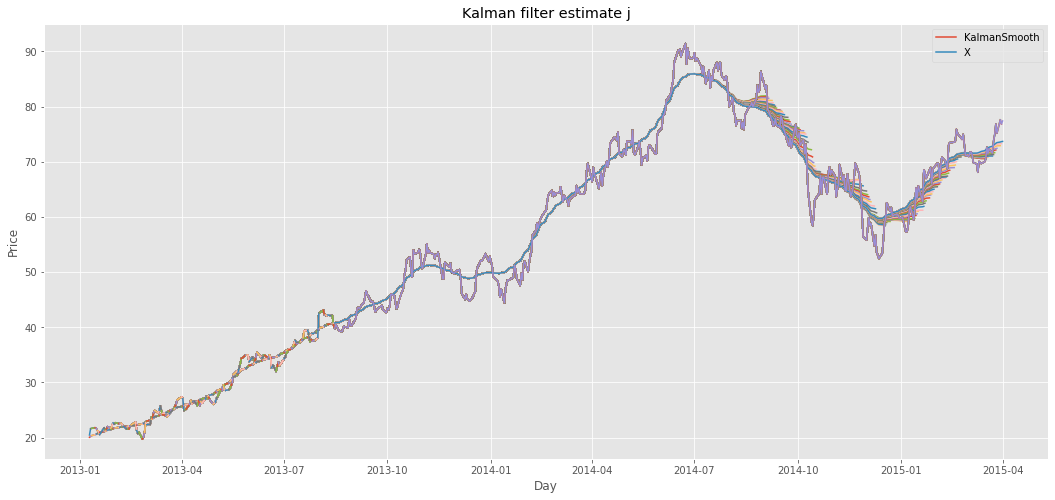

In [16]:
#Para pruebas, ojo que total lengh le sobre mucho al final por lo que quito al pricipio del timeframe
#TOTAL_len =1000

for i in range(TOTAL_len):
    endWindow3   =endWindow2 + dt.timedelta(days=i) # muevo la ventana hacia delante en el tiempo 'dia a dia'
    endWindow    =endWindow3.strftime("%Y-%m-%d")
    print ('end date:', endWindow)
    
    if(endWindow in dff.index):
        df_aux= dff.loc[startWindow:endWindow]       #voy pasando los datos desplazando la ventana
        
        recogo = regreMedia.analisis(instrumento, startWindow, endWindow, df_aux) #Llamada a la clase estrategia. LA CLAVE DE TODO!!!
        
        print ('................................................Analizando, muestra', i, 'de', TOTAL_len, 'fecha', endWindow)
        
        """
        Tratamiento de los returns, mejor en las funciones de analisis que hacer aquí.
        if(recogo['senal'] == 1 ):
            dff.loc[[endWindow],['Senal']]= 1
        elif(recogo['senal'] == 0 ):
            dff.loc[[endWindow],['Senal']]= 0
        elif(recogo['senal'] == -1 ):
            dff.loc[[endWindow],['Senal']]= -1            
        elif(recogo['senal'] == 503 ):
            dff.loc[[endWindow],['Senal']]= 0          
        """
            
    else:
        print('..............Día sin sesión, next please')

        

***Recogemos los datos de las entradas que ha realizado la Estrategia***

In [ ]:
data=rg.StrategyClass.dfLog
#data.dropna(inplace=True) 

In [ ]:
data.tail()

In [ ]:
data['Senal'].plot(title = 'Señales de compra de la estrategia ' )
# Ploteando una parte
#data.loc['2010':'2022','Senal'].plot(title = 'Señales Regresión a la media ' +instrumento,xlim=('2010','2022'))

In [ ]:
tiempo_final = time() 
 
tiempo_ejecucion = (tiempo_final - tiempo_inicial)/60
 
print ('El tiempo de ejecucion fue:',tiempo_ejecucion,"minutos") #En 

In [ ]:
data.loc['2011-01-04':'2019-11-04']

In [ ]:
#Guardamos el resultado del analisis en un pickle
#data.to_pickle("./primerBack_FTNT.pkl")

***3.- Ingeniería de datos para calcular la bondad de la estrategia***

In [ ]:

data['Dif_Close'] = data.Price.pct_change()
data['Retornos'] = data.Dif_Close * data.Senal.shift(1)   
data['Capital'] = (data.Retornos + 1).cumprod() * 100
    
rg.StrategyClass.dfLog=data  #Ojo a esta liena, no me cuadra.

#quant_j.salvarExcel(StrategyClass.dfLog, "log"+instrumento)   
#data.to_pickle('almacen')    #df = pd.read_pickle(file_name)

>Para calcular los retornos del sistema, calculamos la diferencia relativativa entre el precio de cierre y el del día anterior. Para posteriormente multiplicarlo por la señal que del día anterior que nos indicaba la posición a tomar (si estaba comprado, sumo beneficio).

In [ ]:
data.tail()

In [ ]:
data[60:]

>El capital, por comodidad, lo calcularemos en base 100, es decir como si iniciaramos la inversión con 100 unidades monetarias. Para su calculo arrastramos el producto acumulado de los retornos mas 1, multiplicados como dijimos por 100.

Pero para observar gráficamente la evolución del sistema necesitamos un gráfico con mas información. Para ello definimos una función que nos mostrará un gráfico con la evolución de nuestra estrategia, comparandola con la del activo. En un subgráfico se visualizará el drawdown del sistema, comparado de nuevo con el del activo. Y por útlimo las posiciones que toma el sistema.

In [ ]:
def grafico (df):
    estudio = df.copy()
    
    DD_bh, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Dif_Close[60:], info = False) 
    
    DD, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Retornos.fillna(0), info = False) 

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    fig.suptitle('Estrategia vs B & H', fontsize=20)

    #Primer plot analiza la evolcuion de una inversion de 100€ en buy&hold y la estrategia)
    ax1.plot(estudio.Capital)
    ax1.plot((estudio.Price) * (100/estudio.Price[1]))
    ax1.set_title('Capital')
    ax1.legend(['Estrategia','Buy & Hold'])

    ax2.plot(DD*100, c='0.5')
    ax2.plot(DD_bh*100, c='y')
    ax2.fill_between(DD.index, 0, DD*100, color='0.7')
    ax2.set_title('Drawdown')
    ax2.legend(['Estrategia','Buy & Hold'])

    ax3.plot(estudio.Senal, c='orange')
    #ax3.fill_between(estudio.index, 0, estudio.Senal*100, color='orange')
    ax3.set_title('Posición')

    plt.show()
    return

In [ ]:
grafico(data)

---

In [ ]:
#data[55:70]

---

# ANALISIS DEL SISTEMA

In [ ]:
Beneficio_Bruto = data.Capital[-1] - data.Capital[1]
print ('Beneficio Bruto : {:.2f} €  con una inverison de 100€'.format(Beneficio_Bruto))

In [ ]:
#Rentabilidad anual compuesta. Calculamos lo que la inversion se ha incrementado cada año con el interes compuesto
CAGR = analisis.CAGR(data.Retornos)
print ('CAGR : {:.2f}%'.format(CAGR * 100))

In [ ]:
#Ratio calculado restando una rentabilidad segura a nuestra rentabilidad de estrategia y dividido por el riego (=volatilidad)
data.Retornos=data.Retornos.replace(0,np.e)  #Quito los cero (no sepuede hacer logariotmo de cero), pero no se que poner
Sharpe = CAGR / (np.log(data.Retornos + 1).std(skipna=True) * 252 ** 0.5)
print ('Sharpe : {:.3f}'.format(CAGR ))

In [ ]:
# Actualizo la excel con los economic
regreMedia.analisisEconomics(instrumento)

In [ ]:
# Calculo el numero de operaciones

data[55:70]


---


## Cálculo esperanza matemática

(%Aciertos * beneficioMedio )-(%Errores * perdidaMedia)
Nos da idea el benefcio esperado por entrada

In [ ]:
print("Numero operaciones con beneficio ->", 
      data[data['ExitReason'] > 0]['ExitReason'].count()) 
print("Numero operaciones con perdidas ->", 
      data[data['ExitReason'] < 0]['ExitReason'].count()) 
  
data[data['ExitReason']>0]['ExitReason'] 

In [ ]:
data[data['Senal']>0][1:10]

---

In [ ]:
data[data['Senal']>0].index[1]

In [ ]:
# ENTRADAS
print (data[(data['Senal']>0) & (data['Beneficio']>0)].index[0])
data[(data['Senal']>0) & (data['Beneficio']>0) ][0:5] 



In [ ]:
# SALIDA PERDIDAS
print (data[(data['Senal'].shift(1) >0) & (data['ExitReason']== -1)].index[0])
data[(data['Senal'].shift(1) >0) & (data['ExitReason']== -1)][0:5]

In [ ]:
# SALIDA GANANCIAS
data[(data['Senal'].shift(1) >0) & (data['ExitReason']== 1)][0:5]

In [ ]:
serieIndicesENTRADA=data[(data['Senal']>0) & (data['Beneficio']>0)].index

In [ ]:
serieIndicesENTRADA.size

In [ ]:
serieIndicesENTRADA

In [ ]:
serieIndicesEXIT=data[(data['ExitReason']==1) | (data['ExitReason']==-1)].index

In [ ]:
serieIndicesEXIT

In [ ]:
data['ExitReason'][serieIndicesEXIT[2]]

In [ ]:
#Cálculo Esperanza Matemática
countGanando=0
countPerdiendo=0

bolsaGanando=0
bolsaPerdiendo=0

for i in range(serieIndicesENTRADA.size -1):
    if(data['ExitReason'][serieIndicesEXIT[i]] == -1):
        ref1  = data['Price'][serieIndicesEXIT[i]]
        ref2 = data['Price'][serieIndicesENTRADA[i]]
        print (ref1, ref2)
        countPerdiendo= 1+countPerdiendo
        bolsaPerdiendo= bolsaPerdiendo + (ref1-ref2)

    
    if(data['ExitReason'][serieIndicesEXIT[i]] == 1):
        ref1  = data['Price'][serieIndicesEXIT[i]]
        ref2 = data['Price'][serieIndicesENTRADA[i]]
        print (ref1, ref2)
        countGanando= 1+countGanando
        bolsaGanando= bolsaGanando + (ref1-ref2)
print ("bolsa ganando   --> ", bolsaGanando, "   numero operaciones ganando   ", countGanando)   
print ("bolsa perdiendo -->", bolsaPerdiendo, "   numero operaciones perdiendo", countPerdiendo) 
    
    
    
    

In [ ]:
#(%Aciertos * beneficioMedio )-(%Errores * perdidaMedia)

count=countGanando+countPerdiendo

esperanza = (countGanando/count *(bolsaGanando/countGanando))+(countPerdiendo/count *(bolsaPerdiendo/countPerdiendo))
print("ESPERANZA MATEMATICA ES: ", esperanza)
print ("bolsa ganando   --> ", bolsaGanando, "   numero operaciones ganando   ", countGanando)   
print ("bolsa perdiendo -->", bolsaPerdiendo, "   numero operaciones perdiendo", countPerdiendo) 
print ("media perdiendo --> ", (bolsaPerdiendo/countPerdiendo), "  media ganando", (bolsaGanando/countGanando)) 

In [ ]:
countGanando/count

In [ ]:
countPerdiendo/count

In [ ]:
bolsaGanando/countGanando


In [ ]:
(bolsaPerdiendo/countPerdiendo)
